In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from vit.dinocls import DinoClassifier
import torchvision
import matplotlib.pyplot as plt
import timeit
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.tensorboard import SummaryWriter


In [2]:
current_dir = os.path.curdir

DINO_REPO = f"{current_dir}/dinov3"
BACKBONE_PATH = "/storage/experiments-ml/weights/dino/dinov3_vits16_pretrain_lvd1689m-08c60483.pth"
#BACKBONE_PATH = "/storage/experiments-ml/weights/dino/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth"
RANDOM_SEED = 42
BATCH_SIZE = 300
EPOCHS = 25
LEARNING_RATE = 1e-4
NUM_CLASSES = 100
PATCH_SIZE = 8
IMG_SIZE = 32
IN_CHANNELS = 3
NUM_HEADS = 12
DROPOUT = 0.001
# HIDDEN_DIM = 768
HIDDEN_DIM = 256
# HIDDEN_DIM = 8
ADAM_WEIGHT_DECAY = 0.01
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 2
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49
USE_SPECTRE=True
SPECTRE_THRESHOLD=1.0
USE_SPECTRE_VIT=False
EXPERIMENT_NAME="dinov3_s16_cifar100_mean_feat_finetune_regularized_correctnorm"

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = SummaryWriter(f'runs/{EXPERIMENT_NAME}')

dino = torch.hub.load(DINO_REPO, 'dinov3_vits16', source='local', weights=BACKBONE_PATH, skip_validation=True, map_location='cuda')
#dino = torch.hub.load("facebookresearch/dinov2", "dinov2_vits8")
dino.cuda().train()
# Freeze all parameters in the backbone
#for param in dinov3.parameters():
#    param.requires_grad = False

model = DinoClassifier(
    backbone=dino,
    num_classes=NUM_CLASSES).to(device)

Ignored kwargs: {'map_location': 'cuda'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035931915..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27291214..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05886942..1.0439632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26459956..1.4558628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4258603..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21

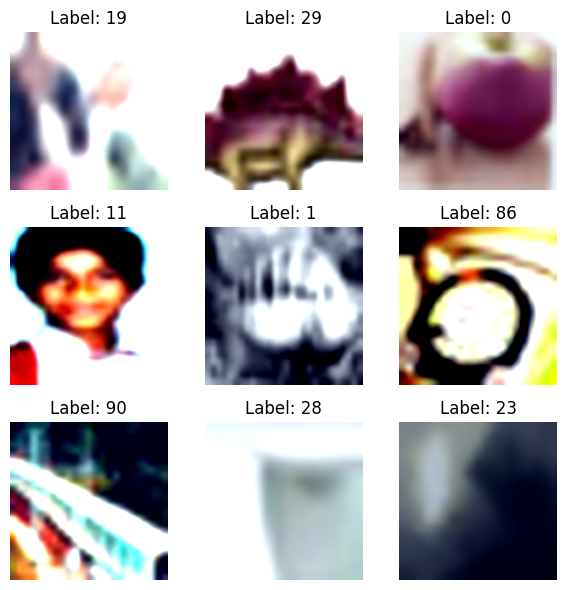

In [3]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        224, scale=(0.2, 1.0),
        interpolation=transforms.InterpolationMode.BICUBIC
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761),
    ),
])

eval_transform = transforms.Compose([
    transforms.Resize(
        256, interpolation=transforms.InterpolationMode.BICUBIC
    ),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761),
    ),
])

# Load CIFAR100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=eval_transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=eval_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Display sample images
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    img =   img.permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
use_amp = True
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
start = timeit.default_timer()
for epoch in range(EPOCHS):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(train_dataloader):
        img = img_label[0].float().to(device)
        label = img_label[1].type(torch.uint8).to(device)
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            train_labels.extend(label.cpu().detach())
            train_preds.extend(y_pred_label.cpu().detach())
            loss = criterion(y_pred, label)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(val_dataloader):
            img = img_label[0].float().to(device)
            label = img_label[1].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
        val_loss = val_running_loss /  (idx + 1)
        writer.add_scalar('Loss/Train', train_loss, epoch + 1)
        writer.add_scalar('Loss/Validation', val_loss, epoch + 1)
        writer.add_scalar('Accuracy/Train', sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels), epoch + 1)
        writer.add_scalar('Accuracy/Validation', sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels), epoch + 1)
        # Save model checkpoint
        torch.save(model.state_dict(), f'checkpoints/dinov3s16_{epoch}.pth')
stop = timeit.default_timer()
writer.add_scalar('Training time', stop - start)
writer.close()
print(f"Training time: {stop - start:.2f}")


Training time: 5124.73
